# Image Processing

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pylab as P
%matplotlib inline

In [11]:
# read file into Python
cap = cv2.VideoCapture('fc2_save_2017-07-13-150630-0000.avi')


## Understanding the Data

To get a sense of the data, I looked at the total number of frames, as well as an example of what a frame looks like and a bacterium in a frame image.

In [12]:
# determine frame rate and number of frames in video
rate = int(cap.get(cv2.CAP_PROP_FPS))
number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print("There are {} frames in the video. The frame rate is {} frames per second.".format(number, rate))

# kill video
cap.release()
cv2.destroyAllWindows()

There are 9000 frames in the video. The frame rate is 30 frames per second.


(-0.5, 39.5, 39.5, -0.5)

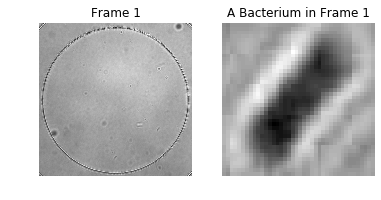

In [18]:
# look at frame 1
plt.figure()
plt.subplot(1,2,1)
plt.imshow(pixel[:,:,0], cmap = 'gray')
plt.title('Frame 1')
plt.axis('off')

# "zoom in" on bacteria
a = 880
b = 920
c = 990
d = 1030

bacteria = pixel[a:b, c:d, 0]

plt.subplot(1,2,2)
plt.imshow(bacteria, cmap = 'gray')
plt.title('A Bacterium in Frame 1')
plt.axis('off')

## Thresholding

Thresholding is a good technique to extract information from images. A binary threshold can be used to isolate the bacteria from a frame. 

In [19]:
# function to obtain pixel values from frames 
# with inputs (video capture, number of frames)

def pixel_fn(cap, f):
    count = 0
    pixel_fn = np.zeros((1300, 1296, f))
    while(cap.isOpened()):
        
        if count == f: # loop through until reach number of frames desired
            break
            
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        pixel_fn[:, :, count] = frame[:, :, 0]
        
        count += 1
    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

    return pixel_fn


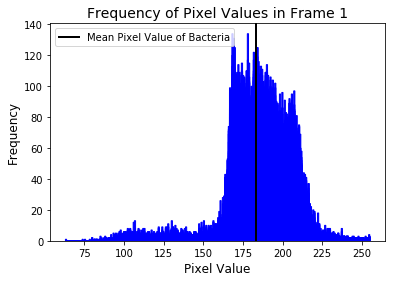

In [21]:
f = 1
cap = cv2.VideoCapture('fc2_save_2017-07-13-150630-0000.avi')
pixel = pixel_fn(cap, f)

histogram = P.hist(pixel[:,:,0], bins=256, histtype='stepfilled')
pretty_histogram = P.setp(histogram[2], color = 'blue')
plt.xlabel('Pixel Value', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Frequency of Pixel Values in Frame 1', fontsize = 14)
plt.axvline(x = bact_mean, color = 'k', linewidth = 2, label = 'Mean Pixel Value of Bacteria')
plt.legend(fontsize = 10)

From the histogram above, it's apparent that binary thresholding alone will not work to isolate the bacteria because the mean pixel value of the bacteria is within the boundaries of the range of common background pixel values, so the bacteria gets "lost" in the background. It is not a simple solution to isolate the bacteria pixel values from the background pixel values to find a threshold.

## Background Subtraction

Even though there are many objects in the image, the image has low resolution, and the bacteria are similar in pixel intensity to the background, somehow our brains are still able to find the bacteria in the video. We're able to do this because the bacteria are move over time. 

Background subtraction allows for the creation of a "background" image composed of pixels whose values remain fairly constant over time. It's reasonable to say that the background image is simply the median pixel value over the entire video. Compared to the mean, the median is not skewed by extreme values, such as brief moments of intense brightness that lights up an entire frame. 


Text(0.5, 1.0, 'Pixel Values in Background Subtracted Image (first 100 frames)')

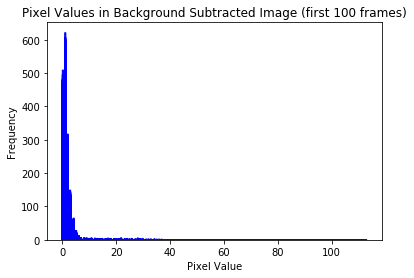

In [26]:
cap = cv2.VideoCapture('fc2_save_2017-07-13-150630-0000.avi')
f = 100
pixel = pixel_fn(cap, f)

median = np.median(pixel, axis = 2) # median pixel across first 100 frames
sub_back = np.zeros((1300, 1296, f)) # initialize array with pixel values after subtracting median

frame = 1 # chosen frame
sub_back = abs(np.copy(pixel[:,:,frame])-median)

histogram = plt.hist(sub_back, bins = 256, histtype = 'stepfilled')
nice_hist = P.setp(histogram[2], color = 'blue')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel Values in Background Subtracted Image (first 100 frames)')

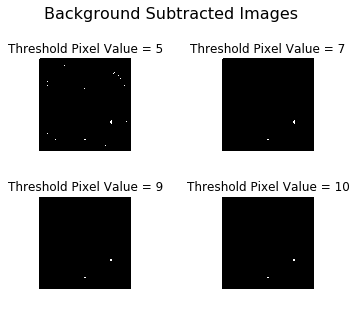

In [42]:
threshold = [5, 7, 9, 10]
count = 0

plt.figure().suptitle('Background Subtracted Images', fontsize=16)
#plt.title('Background Subtracted Images')
for ii in threshold:
    mask_half = sub_back > threshold[count] #pixels in array for each from (from #3) >= threshold
    plt.subplot(2,2, count+1).title.set_text('Threshold Pixel Value = {}'.format(ii))
    plt.imshow(mask_half,cmap = 'gray')
    plt.axis('off')
    count += 1

plt.subplots_adjust(bottom=0, top=0.8, wspace=None, hspace=0.5)

From the histogram above, it's apparent that most of the background pixels have value less than ten. In order to determine the best threshold pixel value to remove the background image, I tested various values. The plots shown above indincate that ten is a good pixel value to use as a threshold.

## Morphological Filtering

After choosing a threshold, a binary image is created. Morphological filtering cleans up the noise around the bacteria in the image. 

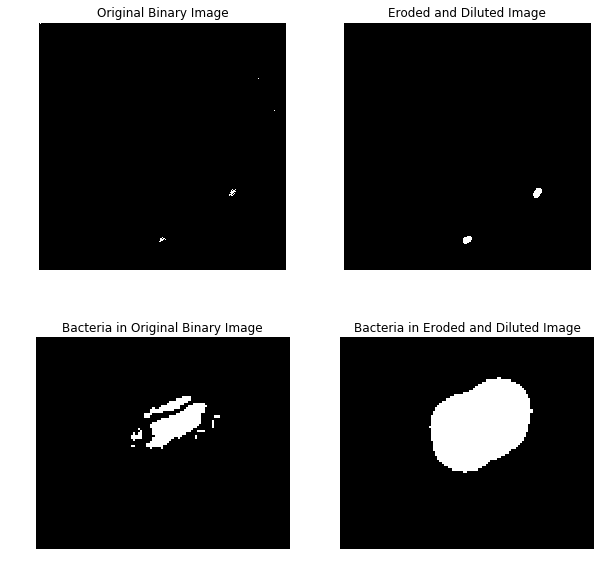

In [60]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

cap = cv2.VideoCapture('fc2_save_2017-07-13-150630-0000.avi')

# image with chosen threshold 10
threshold_image = sub_back > 10

# create binary image
binary = np.copy(threshold_image)
plt.figure(figsize= (10, 10))
plt.subplot(2,2,1).title.set_text('Original Binary Image')
plt.imshow(binary, cmap = 'gray')
plt.axis('off')

#apply erosion and dilution:
eroded = erosion(binary, disk(3))
diluted = dilation(eroded, disk(15))
plt.subplot(2,2,2).title.set_text('Eroded and Diluted Image')
plt.imshow(diluted, cmap = 'gray')
plt.axis('off')

# zoom in to one bacteria:
a = 1100
b = 1200
c = 580
d = 700

zoom_binary = binary[a:b, c:d]
zoom_diluted = diluted[a:b, c:d]

plt.subplot(2,2,3).title.set_text('Bacteria in Original Binary Image')
plt.imshow(zoom_binary, cmap = 'gray')
plt.axis('off')

plt.subplot(2,2,4).title.set_text('Bacteria in Eroded and Diluted Image')
plt.imshow(zoom_diluted, cmap = 'gray')
plt.axis('off')


## Bacteria Trajectories Using Centers of Mass

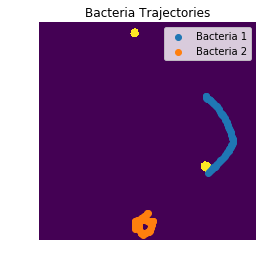

In [61]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

# read file
cap = cv2.VideoCapture('fc2_save_2017-07-13-150630-0000.avi')

# find pixel values from 100 frames
f = 100 # number of frames
pixel = pixel_fn(cap, f) # pixel array

# use median pixel value as threshold 
median = np.median(pixel, axis = 2)
all_median = np.zeros((1300, 1296, f))

for ii in range(f): 
    all_median[:,:,ii] = median[:,:] # find medians

# create threshold background subtracted frame
threshold = 10 
pixel_minus_med = abs(np.copy(pixel - all_median))
threshold_image = pixel_minus_med > threshold


x = np.zeros((2, f))
y = np.zeros((2, f))

for ii in range(f):
    
    # morphological filtering to clean up binary image
    filtered_image = dilation(erosion(threshold_image[:,:,ii], disk(3)), disk(15))
    filtered_image = np.array(filtered_image, dtype = np.uint8)
    
    # identify the two bacteria in the frame
    output = cv2.connectedComponentsWithStats(filtered_image)
    centroids = output[3]
    x[0,ii] = centroids[1,0]
    x[1,ii] = centroids[2,0]
    y[0,ii] = centroids[1,1]
    y[1,ii] = centroids[2,1]
    plt.imshow(filtered_image)

    
# plot trajectories of bacteria
plt.scatter(x[0,:], 1300 - y[0,:], label = 'Bacteria 1')
plt.scatter(x[1,:], 1300 - y[1,:], label = 'Bacteria 2')
plt.xlim(0, 1296) 
plt.ylim(0, 1300)
plt.title('Bacteria Trajectories')
plt.axis('off')
plt.legend()
